In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Reshape, Flatten, Dropout, Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
import glob
from tensorflow.keras.utils import load_img, img_to_array

## Prepare (Real, Fake) Image

(2782, 32, 32, 3)


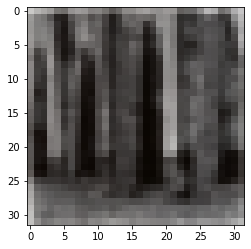

In [27]:
# paths = glob.glob("./Dataset/*/*/*")
paths = glob.glob("./Dataset/Abstract_gallery/Abstract_gallery/*.jpg")
img_size = (32, 32, 3)
train_dataset = []
original_dataset = []

def prep_fn(img):
    img = img.astype(np.float32) / 255.0 # [0,1]
    img = (img - 0.5) * 2  # [0 -0.5 , 1 - 0.5] => [-0.5, 0.5] * 2 => [-1,1]
    return img

for path in paths:
    img = img_to_array(load_img(
        path,
        grayscale=False,
        color_mode='rgb',
        target_size=img_size,
        interpolation='bilinear'
    ))
    # rescale [0,255] -> [-1,1]
    original_dataset.append(img)
    img = prep_fn(img)
    train_dataset.append(img)

plt.imshow(original_dataset[0].astype('uint8'))

train_dataset = np.array(train_dataset)
print(train_dataset.shape)
# datagen=image.ImageDataGenerator(  
#                             # rotation_range=30, zoom_range=0.5,
#                             # width_shift_range=0.2, height_shift_range=0.2,
#                             # shear_range=0.15, horizontal_flip=True,
#                             fill_mode="bilinear",
#                             preprocessing_function=prep_fn
#                           )
# train_generator = datagen.flow_from_directory('./Dataset',
#                                                 target_size=(224,224), color_mode='rgb',
#                                                 batch_size=32,
#                                                 class_mode='categorical', seed = 32,
#                                                 shuffle=True)

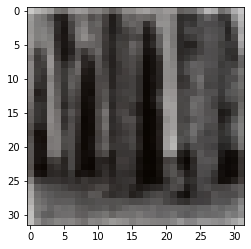

In [28]:
# img_train = (train_dataset).astype('uint8') 
# plt.imshow(img_train[0])

img_train = ((train_dataset/2 + 0.5)*255).astype('uint8')
plt.imshow(img_train[0])

In [29]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0,dataset.shape[0],n_samples)
    X  = dataset[ix]
    y  = np.ones((n_samples,1))
    return X,y

def generate_fake_samples(n_samples,target_size=(32,32,3)):
    h,w,c = target_size
    X  = np.random.uniform(low = 0.0, high = 1.0, size = n_samples * h * w * c)  
    X  = (X - 0.5) * 2
    X  = X.reshape(n_samples,h,w,c)
    y  = np.zeros((n_samples,1))
    return X,y

In [30]:
n_samples = 16
X_real,y_real = generate_real_samples(train_dataset,n_samples)

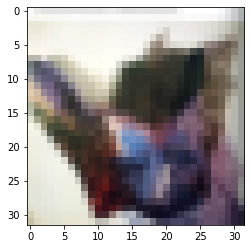

In [31]:
plt.imshow((((X_real[0]/2) + 0.5)*255).astype('uint8'))

In [32]:
X_fake, y_fake = generate_fake_samples(n_samples, img_size)

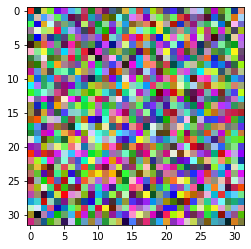

In [33]:
plt.imshow(((X_fake[0]/2 + 0.5)*255).astype('uint8'))

## Create Discriminator

In [34]:
def define_discriminator(in_shape=(32,32,3)):
    # Discriminator use to clarify that the image is real or fake
    # to use as a evaluator of the Model
    model = Sequential()
    # Normal
    model.add(Conv2D(64,(3,3),padding='same',input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # Down Sampling
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())         
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss= 'binary_crossentropy', optimizer=Adam(lr=0.0002,beta_1=0.5), metrics=['accuracy'])
    return model      

In [35]:
def train_discriminator(model, dataset, n_iter=60, n_batch=128, target_size=(32,32,3)):
    half_batch = int(n_batch / 2)
     # manually enumerate epochs
    for i in range(n_iter):
     # get randomly selected 'real' samples
     X_real, y_real = generate_real_samples(dataset, half_batch)
     # update discriminator on real samples
     _, real_acc = model.train_on_batch(X_real, y_real)
     # generate 'fake' examples
     X_fake, y_fake = generate_fake_samples(half_batch, target_size=target_size)
     # update discriminator on fake samples
     _, fake_acc = model.train_on_batch(X_fake, y_fake)
     # summarize performance
     print(real_acc, fake_acc)

In [36]:
d_model = define_discriminator(img_size)
d_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 256)        

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [37]:
train_discriminator(d_model, train_dataset, target_size=img_size)

0.609375 0.0
0.984375 0.0
1.0 0.078125
1.0 0.421875
0.96875 0.703125
1.0 0.984375
0.9375 1.0
0.96875 1.0
0.953125 1.0
0.9375 1.0
0.984375 1.0
0.953125 1.0
0.984375 1.0
0.984375 1.0
0.984375 1.0
0.96875 1.0
1.0 1.0
1.0 1.0
0.96875 1.0
0.984375 1.0
1.0 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


In [38]:
def define_generator(latent_dim, discr_out = (256,4,4)):
    model = Sequential()
    # foundation for 4x4 image
    c, w, h = discr_out
    n_nodes = c * w * h
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((w, h, c)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))


    # # upsample to 64x64
    # model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
    # model.add(LeakyReLU(alpha=0.2))


    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [39]:
latent_dim = 100
mini_size = (4,4)
g_model = define_generator(latent_dim, discr_out = (256,mini_size[0],mini_size[1]))
g_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        524416    
 ranspose)                                                       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

#  GAN

In [40]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator|
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [41]:
def generate_latent_points(latent_dim, n_samples):
   # generate points in the latent space
   x_input = np.random.randn(latent_dim * n_samples)
   # reshape into a batch of inputs for the network
   x_input = x_input.reshape(n_samples, latent_dim)
   return x_input

In [42]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples,1))
    return X, y

In [43]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(
                g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            # # create inverted labels for the fake samples y = 0 with shape (n_batch, )
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print(d_loss1, d_loss2, g_loss)  # summarize loss on this batch
            # evaluate the model performance, every Nepoch
            if (i+1) % 20 == 0:
                summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [44]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(acc_real , acc_fake)
  # save plot
  # save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)

In [45]:
gan_model = define_gan(g_model, d_model)
gan_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [46]:
train(g_model, d_model, gan_model, train_dataset, latent_dim, n_epochs=400)

0.0007331350352615118 1.1339771747589111 0.8112249374389648
0.003678247332572937 0.7049776315689087 1.3018447160720825
0.810282826423645 0.8065853118896484 0.6612935662269592
0.0011720082256942987 1.0754121541976929 0.5981370210647583
0.0011496490333229303 1.0237514972686768 0.6628038883209229
0.029354851692914963 0.8624814748764038 0.8171468377113342
0.0916077122092247 0.6575860977172852 1.1527034044265747
0.16384053230285645 0.4686846137046814 1.5015580654144287
0.513717532157898 0.6121407747268677 0.9967646598815918
0.09998634457588196 0.5058666467666626 1.5196598768234253
0.10583394020795822 0.23939922451972961 2.1653261184692383
0.22166764736175537 0.18288174271583557 2.102222204208374
0.25648608803749084 0.28776466846466064 1.6120624542236328
0.07185789197683334 0.3509579300880432 1.8562357425689697
0.1346326768398285 0.28964969515800476 2.12320613861084
0.19233781099319458 0.30733197927474976 2.1721577644348145
0.11237639933824539 0.20705048739910126 2.5258941650390625
0.2192757

In [47]:
X,_ = generate_fake_samples(g_model,latent_dim,n_samples)

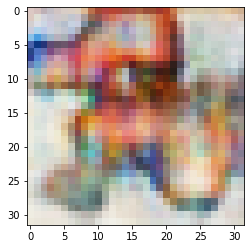

In [57]:
# print(X.shape)

plt.imshow(((X[3]/2 + 0.5)*255).astype("uint8"))
def printImage(X):
    index = 0
    f, ax = plt.subplots(4, 4, figsize=(12,12))  # figsize=(20, 20)
    for i in range(4):
        for j in range(4):
            ax[i, j].imshow(((X[index]/2 + 0.5)*255).astype("uint8"))  # 1-8
            index += 1
    plt.show()

./generator_model_020.h5


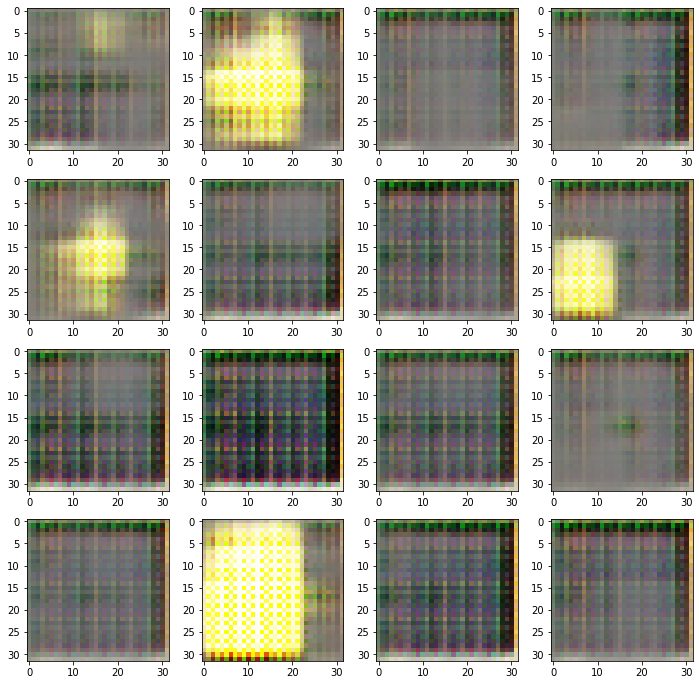

./generator_model_040.h5


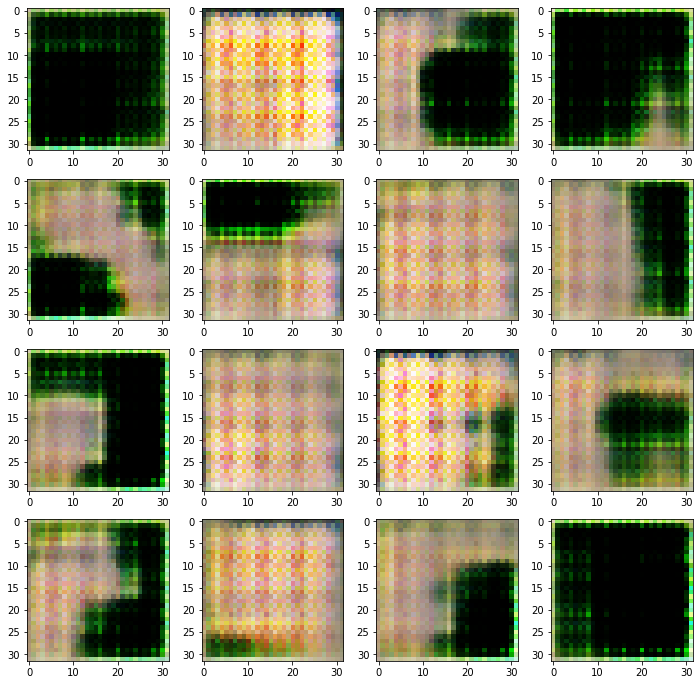

./generator_model_060.h5


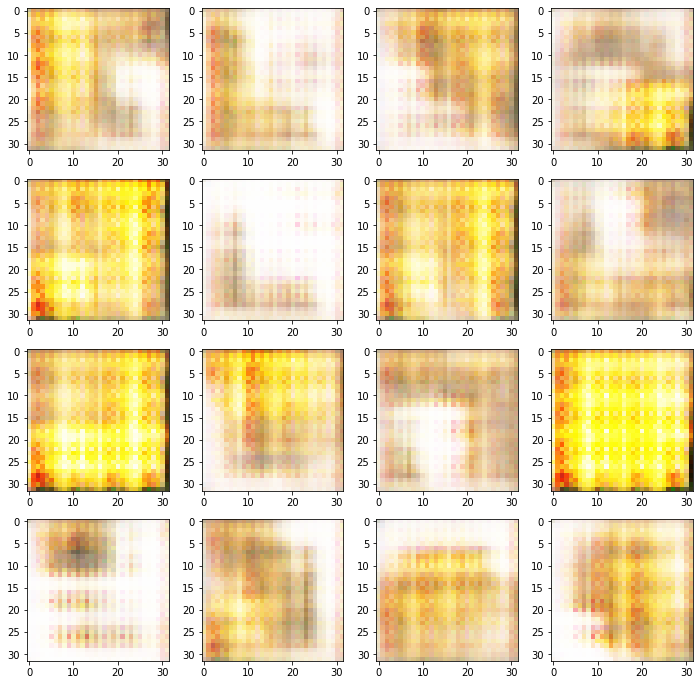

./generator_model_080.h5


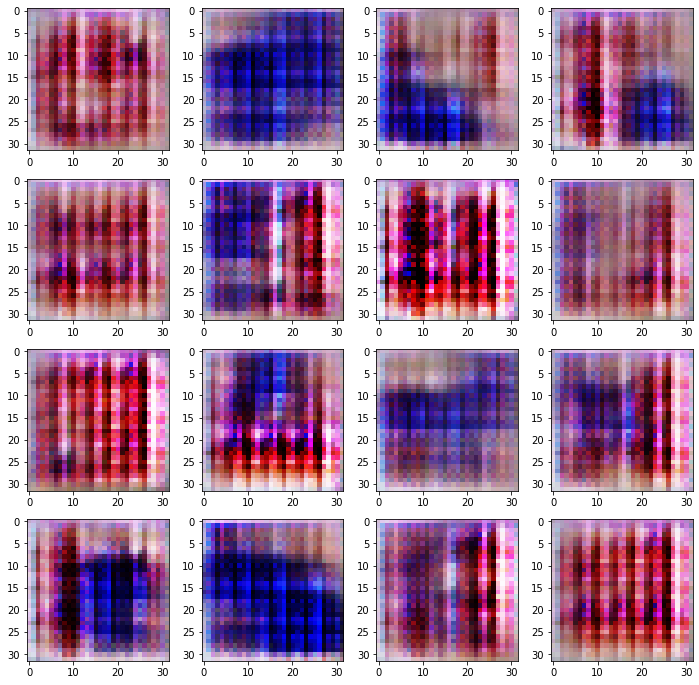

./generator_model_100.h5


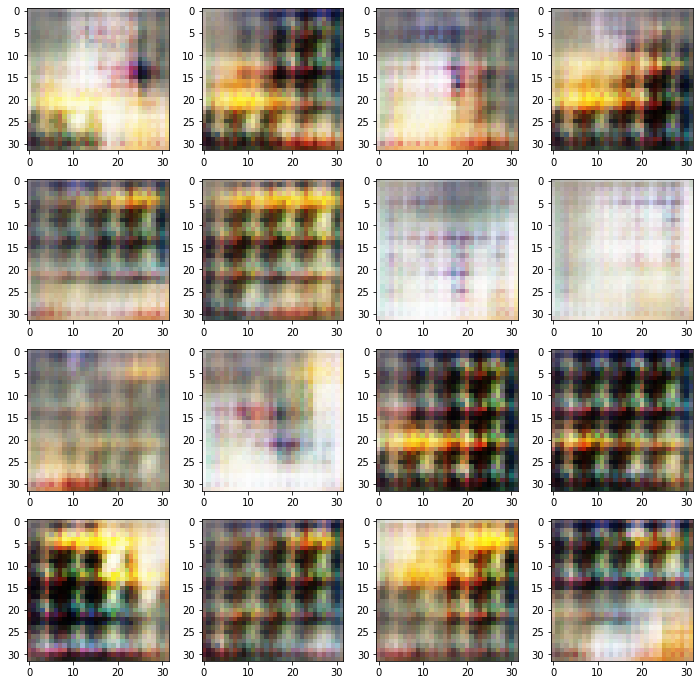

./generator_model_120.h5


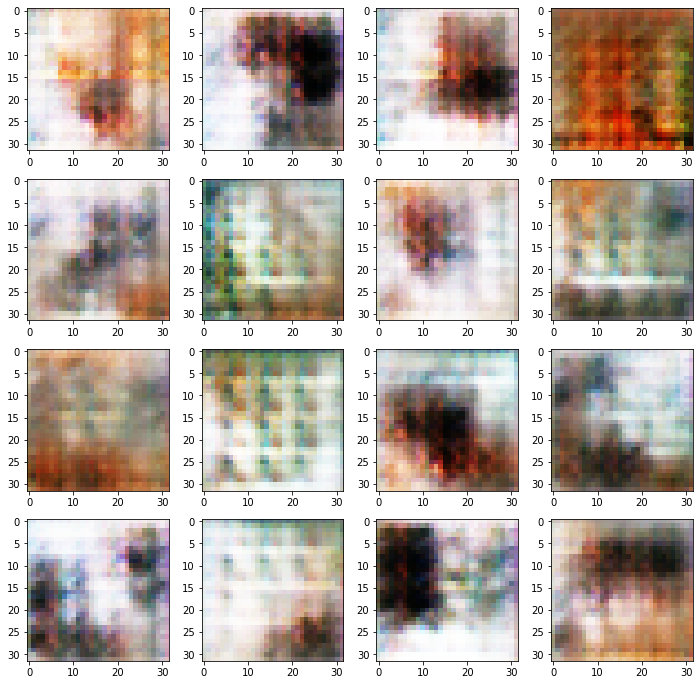

./generator_model_140.h5


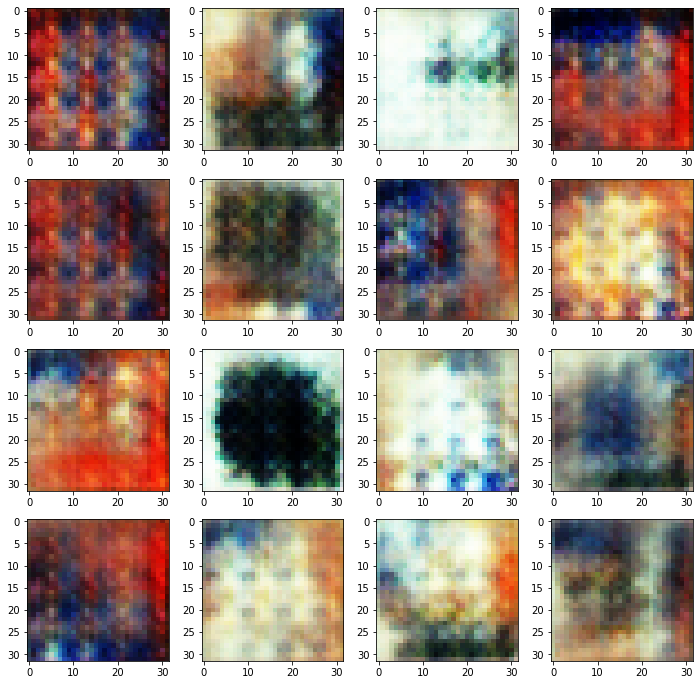

./generator_model_160.h5


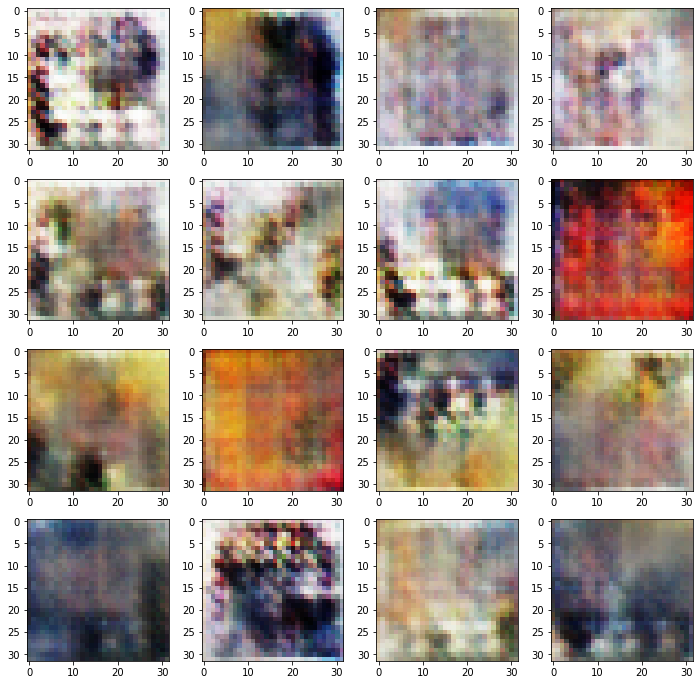

./generator_model_180.h5


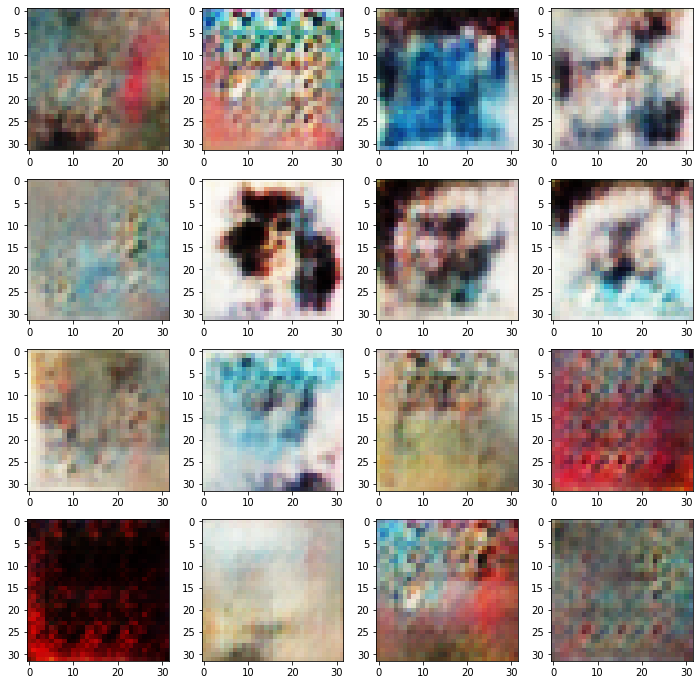

./generator_model_200.h5


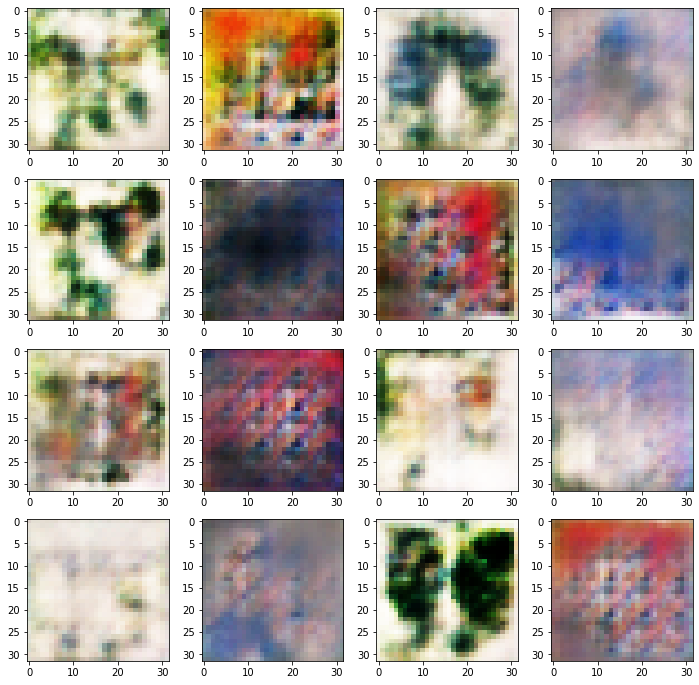

./generator_model_220.h5


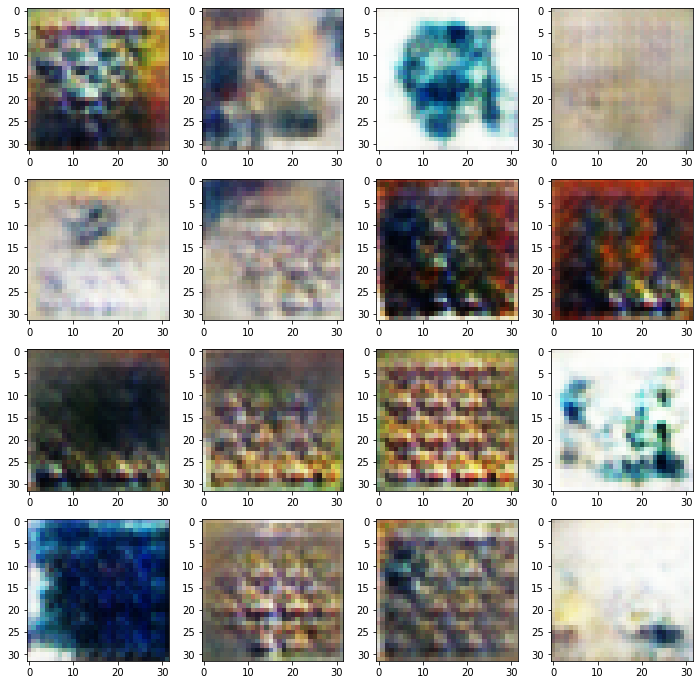

./generator_model_240.h5


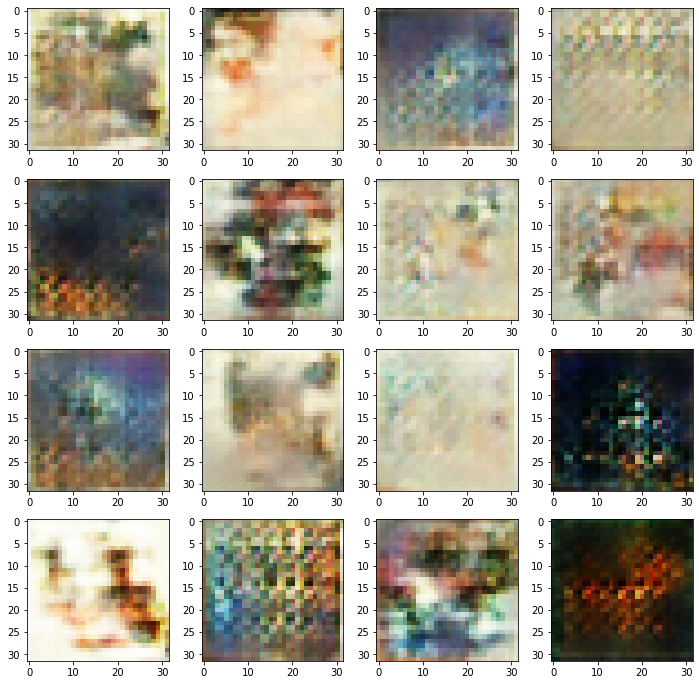

./generator_model_260.h5


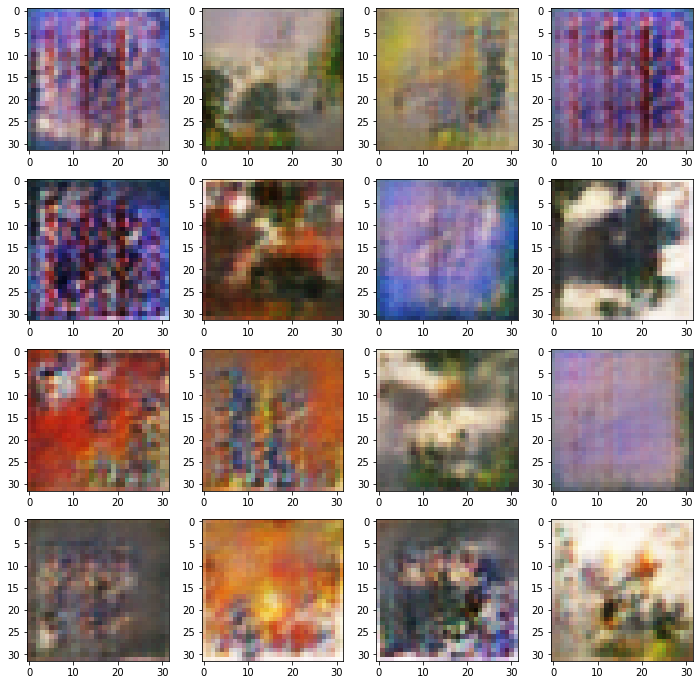

./generator_model_280.h5


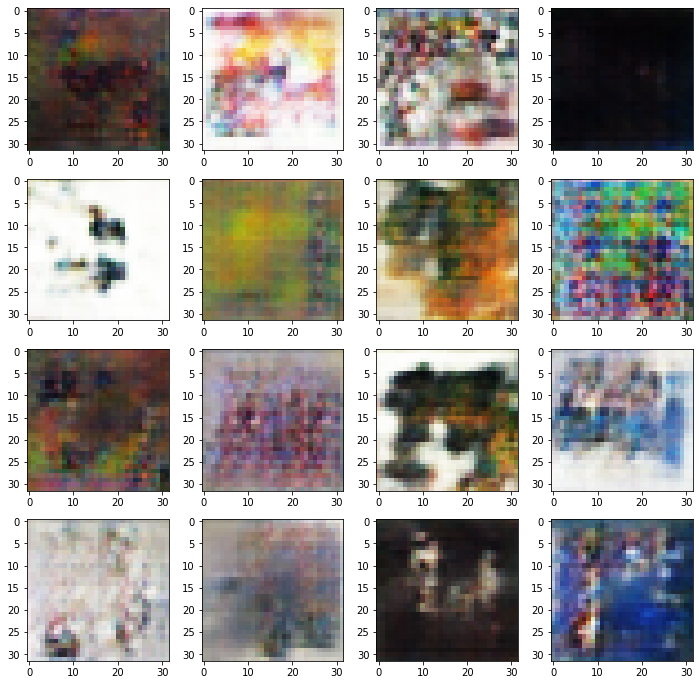

./generator_model_300.h5


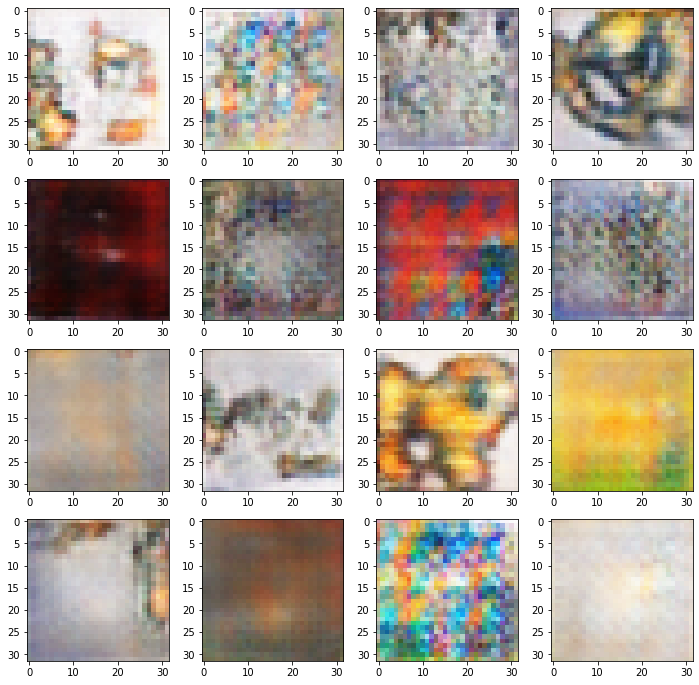

./generator_model_320.h5


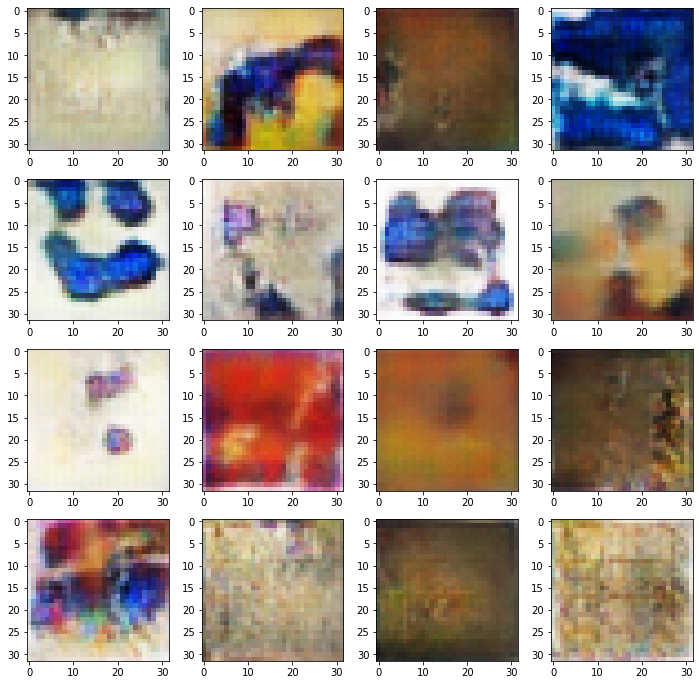

./generator_model_340.h5


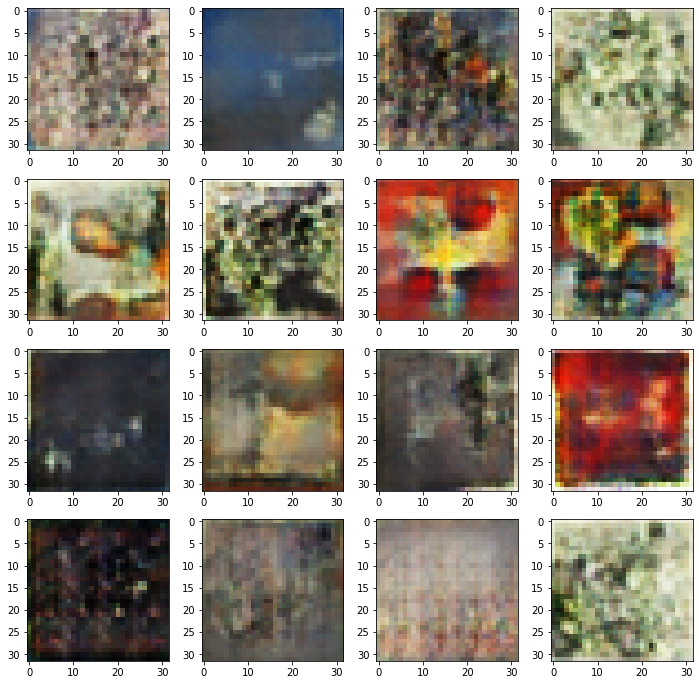

./generator_model_360.h5


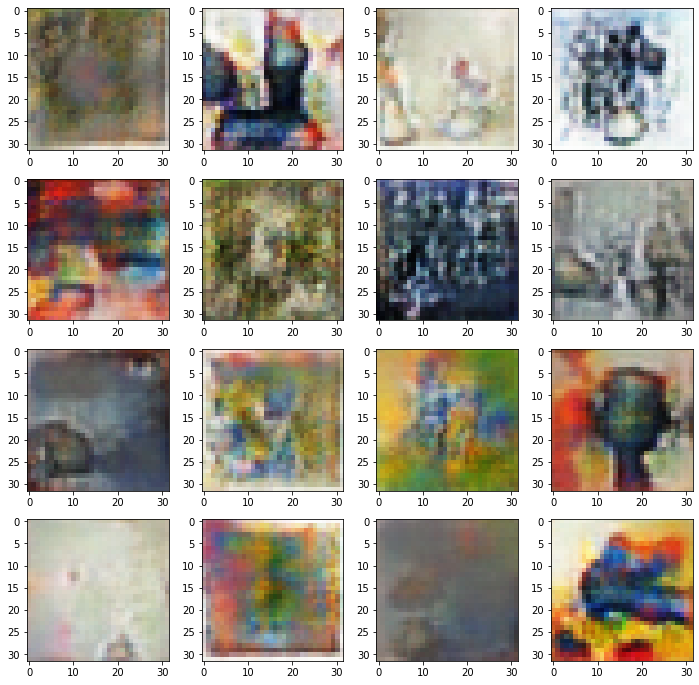

./generator_model_380.h5


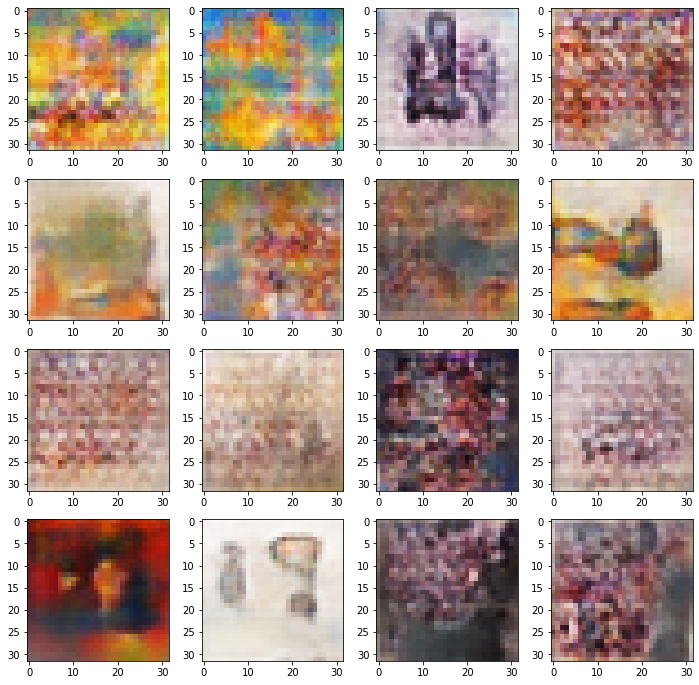

./generator_model_400.h5


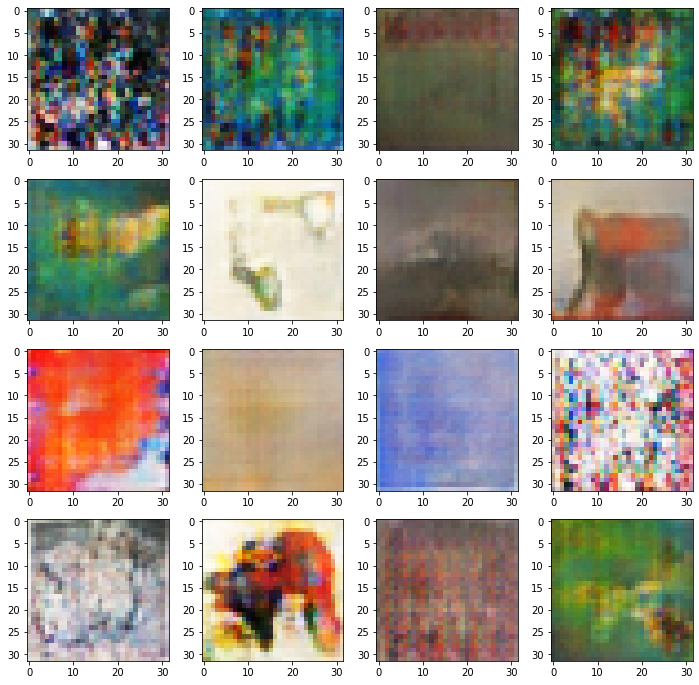

In [50]:
for i in range(20):
    path = './generator_model_%03d.h5' % ((i+1)*20)
    print(path);
    model = keras.models.load_model(path)
    X_during,_ = generate_fake_samples(model, latent_dim, n_samples)
    printImage(X_during)